# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau

  - Exemples de référence

  - Analyse des ensembles de niveau (Q1, Q2, Q3, Q4)

- Construction des courbes de niveau

  - Méthode de Newton (Q5, T1, T2)

  - Génération des points (Q6, T3)

  - Bouclage et auto-intersection (Q7, T4, T5)

- Post-traitement

  - Interpolation (Q8, T6)

  - Intégration (T7, T8)

## Préambule

### Dépendances logicielles 

In [5]:
# Python Standard Library
# -----------------------
pass

# en effet, il n'y a rien à mettre

In [6]:
# Third-Party Libraries
# ---------------------

# Autograd & Numpy (que l'on a installé)
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [7]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [8]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

#### Exemples d'usage

In [9]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(0.0, 0.0) # array([1., 2.])

array([1., 2.])

In [10]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

#### Précautions

Les deux sources d'erreurs (avec messages cryptiques) les plus communes avec autograd :

**Selection de NumPy**

N'importez pas NumPy directement, par exemple avec

    >>> import numpy as np # Wrong !

mais importez le module `numpy` qui a été modifié par `autograd` (pour que les fonctions du module "coopérent" avec les algorithmes de différentiation automatique). 

    >>> import autograd.numpy as np # Right !
    
Utilisez-le ensuite comme vous le feriez avec NumPy classique.

**Utilisez des doubles**

Les fonctions générées par autograd sont strictes quand au type des nombres utilisés (plus strictes que les fonctions NumPy) : il doit s'agir de doubles. Par exemple, si l'on définit

    >>> def add(x, y):
    ...    return x + y
    >>> grad_add = grad(add)

Alors `grad_add(0.0, 0.0)` renvoie `array([1.0, 1.0])`, mais `grad_add(0, 0)` génère une erreur, car ses arguments sont des entiers et non des doubles.


## Ensembles de niveau

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x_1,x_2) \in \mathbb{R}^2 \; | \; f(x_1, x_2) = c\}.
$$


### Exemples de référence

On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [11]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [12]:
def f1(x1, x2):
    x1 = np.array(x1)
    x2 = np.array(x2)
    return 3.0 * x1 * x1 - 2.0 * x1 * x2 + 3.0 * x2 * x2 


In [13]:
# Exemples de valeurs de f1
print(f1(1,0))
print(f1(0,0))
print(f1(1,1))

3.0
0.0
4.0


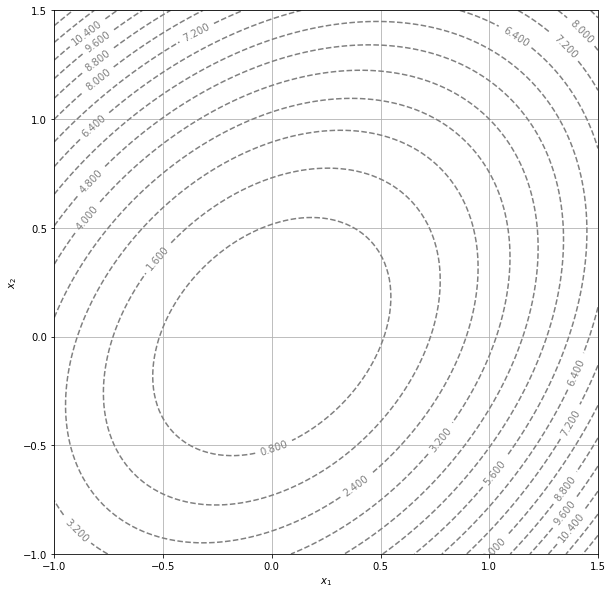

In [14]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.5, 100), 
    y=np.linspace(-1.0, 1.5, 100), 
    levels=15 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x_1,x_2) \in \mathbb{R}^2 \mapsto (x_1 - 1)^2 + (x_1 - x_2^2)^2
$$

In [15]:
def f2(x1, x2):
    return (x1 - 1)**2 + (x1 - x2**2)**2

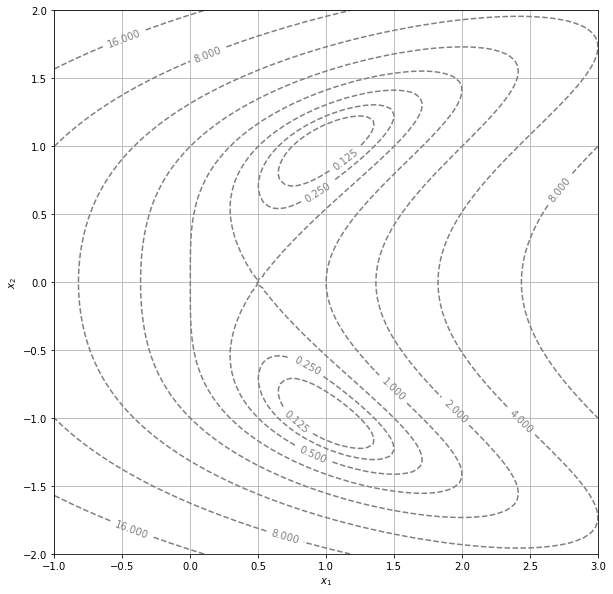

In [16]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [17]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

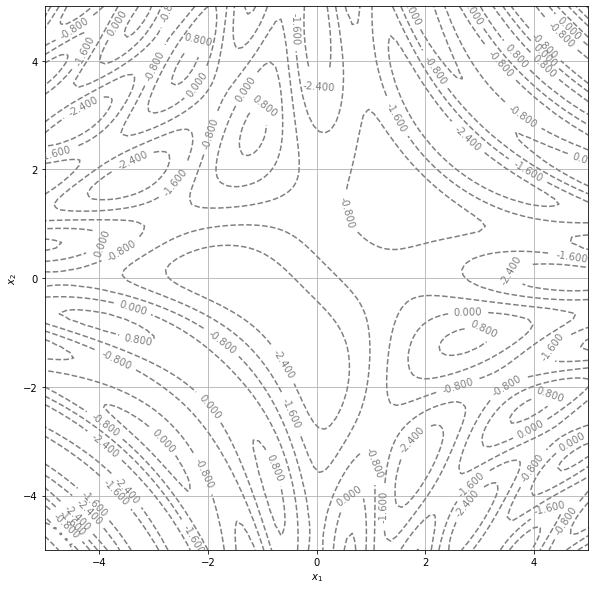

In [18]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

### Analyse des ensembles de niveau

#### Question 1

Soit $c \in \mathbb{R}$.
On suppose que la fonction $f:\mathbb{R}^2 \to \mathbb{R}$ est continue et vérifie
$f(x_1, x_2) \to +\infty$ quand $\|(x_1,x_2)\| \to +\infty$.
Que peut-on dire de l'ensemble de niveau $c$ de $f$ ?

L'ensemble de niveau $c$ de $f$ est fermé et borné.

### Fermé
Soit $(p_i)$ une suite de points de la courbe de niveau convergeant vers un point $p$.

On a alors par continuité de $f$ : $ f(pi) \rightarrow  f(p)$.

Or $\forall i, f(pi) = c$, et donc $f(p) = c$ par unicité de la limite.

Ainsi, $p$ est dans la courbe de niveau qui est donc fermée.


### Borné
Raisonnons par l'absurde 



Dans la suite la fonction $f$ est supposée continûment différentiable. On suppose également que le gradient $\nabla f$ ne s'annule pas dans un voisinage du point $x_0 = (x_{10}, x_{20}) \in \mathbb{R}^2$. On pose alors
$$
p(x_1, x_2) := \frac{\partial_2 f(x_0)}{\|\nabla f(x_0)\|} (x_1 - x_{10}) -
\frac{\partial_1 f(x_0)}{\|\nabla f(x_0)\|} (x_2 - x_{20}).
$$




#### Question 2
Comment interpréter géométriquement le terme $p(x_1,x_2)$ ?

#### Question 3

Montrer que dans un voisinage ouvert de $x_0$, on peut paramétriser l'ensemble de niveau $c:=f(x_0)$ au moyen de $p(x_1,x_2),$ c'est-à-dire qu'il existe un $\varepsilon > 0$ et une fonction (continûment différentiable) $\gamma :\left]-\varepsilon,\varepsilon \right[ \to \mathbb{R}^2$ tels que dans un voisinage ouvert de $x_0,$ $f(x_1,x_2) = c$ si et seulement si $(x_1, x_2) = \gamma(t)$ où $t = p(x_1, x_2)$.

#### Question 4

Montrer que pour tout $t \in \left]-\varepsilon, \varepsilon \right[$ :

  - le vecteur $\gamma'(t)$ est non nul (il fournit donc une tangente au chemin $\gamma$),

  - est orthogonal à $\nabla f(\gamma(t))$.

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $x_0 \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

#### Question 5

L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

Non, elle n'en demande pas.
En effet, puisque la ligne de niveau est destinée à être observée sur un graphe par un humain, il n'est pas nécessaire d'avoir une très grande précision. De plus, il risque d'y avoir beaucoup d'erreurs d'arrondi dans les calculs effectués, $\varepsilon$ ne peut pas être trop petit (on pourra penser à la recherche du $h$ optimal dans la méthode des différences finies).
Il est possible de faire un calcul, en prenant par exemple que $600$ pixels correspondent à $3$ graduations à l'écran pour une fonction usuelle. On distingue alors jusqu'à $0.005$ d'une graduation en termes d'écart. Ainsi, $\varepsilon = 10^{-4}$ pourrait convenir. Pour avoir un peu de marge, $\varepsilon = 10^{-6}$ convient parfaitement.

In [19]:
N = 100
eps = 1e-6

#### Tâche 1

Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [20]:
def Newton(F, x0, y0, eps=eps, N=N):
    """
        Fonction utilisant la méthode de Newton sur la fonction F de R^2 dans R^2, avec un terme initial [x0, y0]
        L'égalité est vérifiée à eps près.
        On effectue au plus N itérations pour la convergence (cela évite des boucles infinies en cas de non-convergence).
    """

    j = J(F) # fonction qui retourne la matrice jacobienne de F en un point

    for i in range(N):
        ji = np.linalg.inv(j(x0,y0)) # inverse de la jacobienne de F en [x0,y0]
        x, y = np.array([x0,y0]) - np.dot(ji, F(x0,y0)) # Calcul du terme suivant de la suite

        # Vérification de la convergence
        if np.sqrt((x - x0)**2 + (y - y0)**2) <= eps:
            return x, y

        x0, y0 = x, y # Mise à jour des valeurs de la suite
    else:
        raise ValueError(f"no convergence in {N} steps.")

#### Tâche 2

Testez votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x_1, x_2)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x_1 = x_2$ en utilisant le point initial $(0.8, 0.8)$. Puis de faire varier le point initial, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

In [21]:
def f1_inter_bissectrice(x,y):
    return np.array([f1(x,y)-0.8,x-y])

xinf, yinf = Newton(f1_inter_bissectrice, 0.8, 0.8)
print(f"Premier test : ({xinf},{yinf})")
xinf2, yinf2 = Newton(f1_inter_bissectrice, 1.0, 0.7)
print(f"Deuxième test : ({xinf2},{yinf2})")

def f1_inter_droite(x,y):
    return np.array([f1(x,y)-0.8,x+2*y])
xinf3, yinf3 = Newton(f1_inter_droite, 1.0, 0.7)
print(f"Troisième test : ({xinf2},{yinf2})")

def f2_test(x,y):
    return np.array([f2(x,y)+1.6,x-y])
try:
    print(f"Quatrième test : {Newton(f2_test , 0.8,0.8)}")
except:
    print(f"Quatrième test : ne converge pas (cohérent avec le graphe de f2)")
    
def f2_test(x,y):
    return np.array([f2(x,y)-0.5,x-y])
print(f"Cinquième test : {Newton(f2_test , 0.8, 0.8)}")

def f3_test(x,y):
    return np.array([f3(x,y)+1.6,x-y])
print(f"Sixième test : {Newton(f3_test, 0.8,0.8)}")

Premier test : (0.4472135954999579,0.4472135954999579)
Deuxième test : (0.4472135954999596,0.4472135954999596)
Troisième test : (0.4472135954999596,0.4472135954999596)
Quatrième test : ne converge pas (cohérent avec le graphe de f2)
Cinquième test : (0.32814024896098204, 0.32814024896098204)
Sixième test : (0.20522876407978566, 0.20522876407978566)


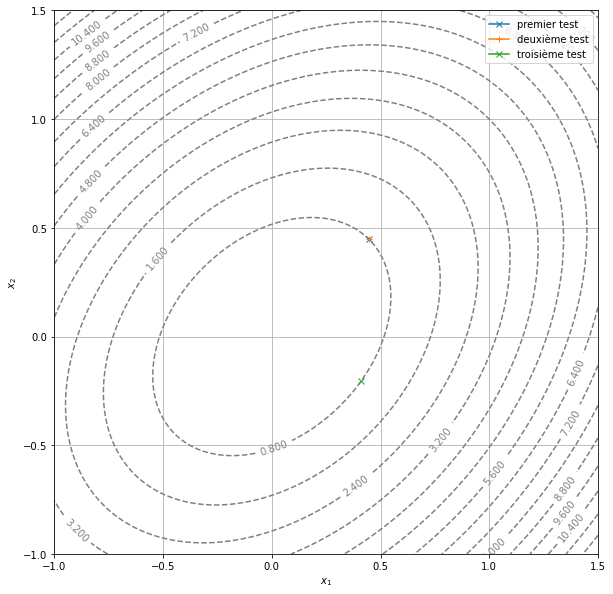

In [22]:
# On représente les trois premiers résultats
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.5, 100), 
    y=np.linspace(-1.0, 1.5, 100), 
    levels=15 # 10 levels, automatically selected
)

plt.plot([xinf],[yinf], marker='x', label = 'premier test')
plt.plot([xinf2],[yinf2], marker='+', label = 'deuxième test')
plt.plot([xinf3],[yinf3], marker='x', label = 'troisième test')
plt.legend();

### Génération des points

#### Question 6 + Tâche 3
Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille `(2, N)` contenant les coordonnées des points correspondants, puis valider graphiquement le résultat au moyen des exemples de référence.

Pour appliquer la méthode de Newton, il nous faut une fonction de $\mathbb{R}^2$ dans $\mathbb{R}^2$. 

On définit donc la fonction paramétrée par $(x_0, y_0)$ (et $\delta$) à utiliser dans la méthode de Newton :

$\begin{array}{ccccc}
F & : & \mathbb{R}^2 & \to & \mathbb{R}^2 \\
 & & (x,y) & \mapsto & (f(x,y)-c, (x-x_0)^2 + (y-y_0)^2 - \delta^2) \\
\end{array}$

On obtiendra donc un point qui vérifiera les deux premières conditions.
Pour vérifier la troisième, il faut bien choisir le point initial de la méthode de Newton. Par ailleurs, pour certains points, cela ne converge pas (`singular matrix` - surtout si le gradient est nul, mais ce n'est pas le cas dans la fonction considérée par l'énoncé - ou non convergence).

On reprend donc l'idée introduite par la fonction $p$. On introduit le vecteur $\overrightarrow{u}$ qui est la rotation du gradient en $(x_0,y_0)$ de $-\dfrac{\pi}{2}$. On le normalise et on le multiplie par $\delta$. Si $\delta$ est du bon ordre de grandeur, c'est-à-dire inférieur ou égal à celui de l'ordre de grandeur du rayon de courbure de la courbe en ce point, la méthode fonctionne et l'on obtient le point souhaité.

Si le gradient s'annule, ce qui n'est pas le cas dans les hypothèses de l'énoncé mais qui a lieu en $(0,0)$ pour la fonction de Rosenbrock, la méthode de fonctionne pas : la jacobienne est non inversible ou le point obtenu n'est pas celui souhaité.

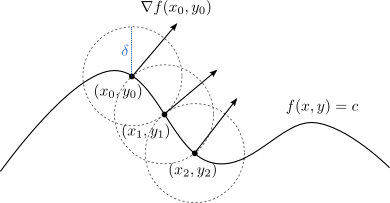

In [23]:
def level_curve(f, x0, y0, delta=0.1, N=1000, eps=eps):
    """
        Première version de la fonction calculant une ligne de niveau
        Attention : N désigne le nombre de point à placer
    """

    c = f(x0, y0) #niveau de la courbe

    def f_Newton(xd,yd): # fonction à passer à la méthode de Newton
        return lambda x,y : (np.array([f(x,y)-c,(x-xd)**2+(y-yd)**2-delta**2]))
    
    def vect_tangent(x,y): # vecteur tangent à la courbe dans la bonne direction
        gx,gy= grad(f)(x,y)
        ux,uy= gy,-gx # rotation
        nu = np.linalg.norm(np.array([ux,uy]),2) # calcul de la norme 2 du vecteur u
        ux,uy=ux/nu*delta,uy/nu*delta # normalisation
        return ux,uy
        
    # le code en commentaires permet d'afficher les courbes de niveaux d'une fonction déjà existante et de tracer les points que l'on calcule directement
    """ plt.close() # affichage des lignes de niveau déjà existantes
    display_contour(
        f, 
        x=np.linspace(-1.0, 3.0, 100), 
        y=np.linspace(-2.0, 2.0, 100), 
        levels=[2**i for i in range(-3, 8)]
    ) """


    t = [(x0, y0)] # point initial qui est sur la courbe
    for i in range(N-1): # boucle qui trace les N-1 points demandés
        x, y = t[-1]
        """ plt.plot([x], [y],'+',color='b', label=f"p{i}")
        plt.annotate(f"p{i}", (x,y)) """
        ux,uy=vect_tangent(x,y) # utile pour choisir le point initial de la méthode de Newton
        t.append(Newton(f_Newton(x,y), x+ux, y+uy, eps)) # le N a une autre signfication pour la méthode de Newton
        
    """ plt.plot([t[-1][0]], [t[-1][1]],'+',color='b', label=f"p{N-1}") #dernier point 
    plt.annotate(f"p{N-1}", (t[-1][0], t[-1][1]))
    plt.legend() """
    return np.array(t).T #le rend sous la bonne forme


Passons aux tests maintenant et aux représentations graphiques.

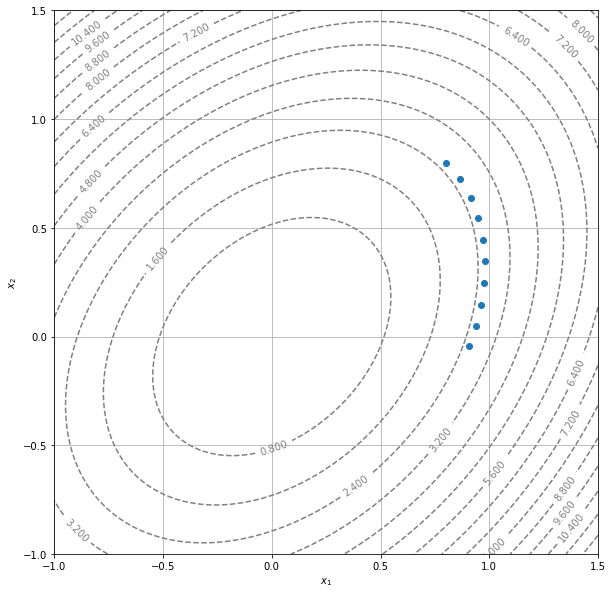

In [24]:
# Test 1

display_contour(
    f1, 
    x=np.linspace(-1.0, 1.5, 100), 
    y=np.linspace(-1.0, 1.5, 100), 
    levels=15 # 10 levels, automatically selected
)
plt.scatter(*level_curve(f1, 0.8, 0.8, 0.1, 10))

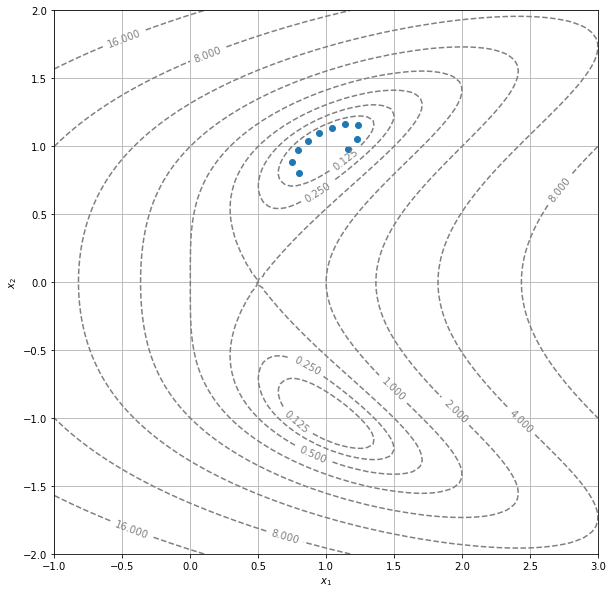

In [25]:
# Test 2

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.scatter(*level_curve(f2, 0.8, 0.8, 0.1, 10))

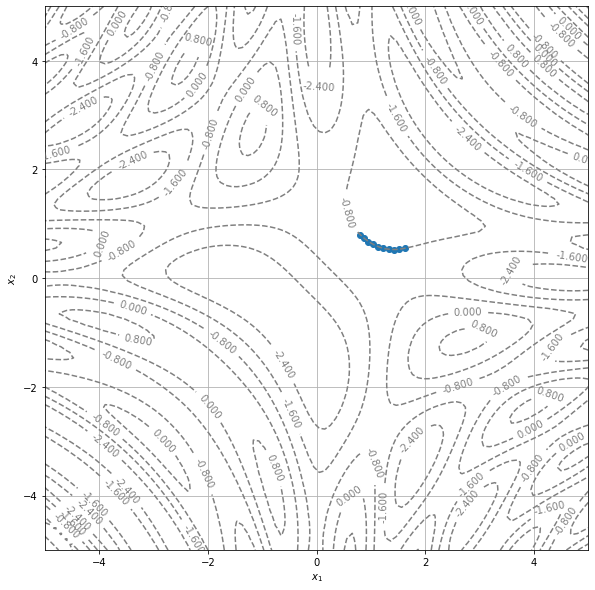

In [26]:
# Test 3

display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

plt.scatter(*level_curve(f3, 0.8, 0.8, 0.1, 10))

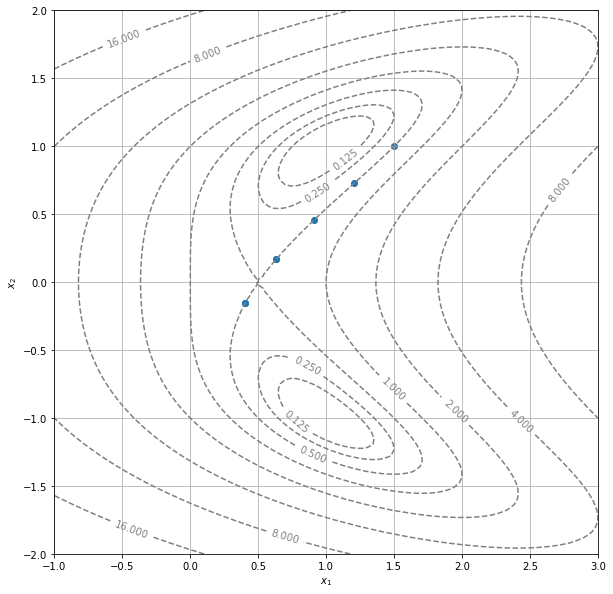

In [27]:
# Test 4 (qui doit ne pas fonctionner) car va aller sur un point critique

display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

plt.scatter(*level_curve(f2, 1.5, 1.0, 0.4, 7)) # rebrousse chemin...

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

#### Question 7 + Tâche 4

Proposer une nouvelle implémentation de `level_curve` qui arrête l'algorithme et renvoie les points connus quand le segment formé par les deux derniers points produits intersecte l'un des segments produits auparavant. En étant (raisonnablement) optimiste, doit-t'on prendre la peine de tester l'intersection du dernier segment avec tous les segments déjà produits (ce qui prend du temps ...) ou juste avec le premier ? Pour répondre à cette question, on pourra se demander si les courbes de niveau similaires à celle de la fonction de Rosenbrock passant par le point $(0.5, 0)$ (cf. Exemples de référence) -- c'est-à-dire "auto-intersectantes" -- sont fréquentes ou rares et pourquoi.

En étant optimiste, il suffit de tester l'intersection du dernier segment avec le premier produit, pour gagner en complexité sans fournir une réponse erronée dans la majorité des cas. En effet, même si cela pourrait problème pour des courbes auto-intersectantes, ces événements sont rares. Certes, on remarque un point pathologique de la fonction de Rosenbrock - en raison d'une boucle -, mais c'est un point critique où le gradient s'annule. Cela est contradictoire aux hypothèses de l'énoncé sur $f$. De plus, dans les autres exemples, on remarque que l'on n'a pas de boucles, ce qui est cohérent avec le caractère peu usuel de fonctions ne vérifiant pas les critères en certains points. Enfin, d'après Wikipédia, la fonction de Rosenbrock est utilisée pour tester les algorithmes d'optimisation, ce qui peut laisser penser qu'elle présente plusieurs motifs complexes à gérer pour les algorithmes.

Pour déterminer si deux segments se coupent, nous avons recherché des méthodes efficaces sur Internet.

In [73]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect_v(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

#test avec distance calcul segment ??

#attention problème de colinéarité
#https://stackoverflow.com/questions/3838329/how-can-i-check-if-two-segments-intersect
def cross_product(p1, p2):
	return p1[0] * p2[1] - p2[0] * p1[1]


def subtract(self, p):
  	return [self[0] - p[0], self[1] - p[1]]
def direction(p1, p2, p3):
	return  cross_product(subtract(p3,p1), subtract(p2,p1))
# checks if line segment p1p2 and p3p4 intersect
def intersect(p1, p2, p3, p4):
    d1 = direction(p3, p4, p1)
    d2 = direction(p3, p4, p2)
    d3 = direction(p1, p2, p3)
    d4 = direction(p1, p2, p4)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and \
        ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True

    elif d1 == 0 and on_segment(p3, p4, p1):
        return True
    elif d2 == 0 and on_segment(p3, p4, p2):
        return True
    elif d3 == 0 and on_segment(p1, p2, p3):
        return True
    elif d4 == 0 and on_segment(p1, p2, p4):
        return True
    else:
        return False

def intersect_s(p1, p2, p3, p4):
    x0 = p1[0]
    y0 = p1[1]
    a0 = (p2[0]-x0)
    b0 = (p2[1]-y0)
    #print(a0,b0)

    x1 = p3[0]
    y1 = p3[1]
    a1 = (p4[0]-x1)
    b1 = (p4[1]-y1)
    #print(a1,b1)



    tx = -1
    ty = -1
    if (a0-a1)!= 0:
        tx = (x1-x0)/(a0-a1)
    else:
        return False #-1,0
    if (b0-b1)!= 0:
        ty = (y1-y0)/(b0-b1)
    else:
        return False#0,-1

    print(p1, p2, p3, p4)
    print(a0, b0, a1, b1, tx,ty)
    return 0 <= tx <= 1 and 0 <= ty <= 1 #tx,ty # tx et ty entr

def intersect_s(p1, p2, p3, p4):
    a = p2[0]-p1[0]
    b = p3[0]-p4[0]
    e = p3[0]-p1[0]
    c = p2[1]-p1[1]
    d = p3[1]-p4[1]
    f = p3[1]-p1[1]

    det = a*d-b*c
    if det != 0:
        alpha = (e*d-b*f)/det
        beta = (a*f-e*c)/det
        print(alpha,beta)
        return  0 <= alpha <= 1 and 0 <= beta <= 1
    else:
        return False

print(intersect_s([0.0,0.0],[1.0,0.0],[0.0, 1.0],[0.0,0.0]))
print(intersect_s([0.0,0.0],[1.0,0.0],[1.0, 1.0],[0.0,-1.0]))
print(intersect_s([0.0,0.0],[1.0,0.0],[0.0, 1.0],[1.0,1.0]))
print(intersect_s([0.0,0.0],[1.0,0.0],[0.0, 1.0],[1.0,2.0]))
print(intersect_s([0.0,0.0],[1.0,0.0],[-1.0, 0.0],[-1.0,5.0]))
print(intersect_s([0.0,0.0],[1.0,0.0],[1.0, 0.0],[1.0,5.0]))




def level_curve2(f, x0, y0, delta=0.1, N=1000, eps=eps):
    #print("g", gx,gy)
    #lagragien, problème de dimension sinon
    c=f(x0,y0)
    def fbis(x,y,xd,yd):
        #d = np.linalg.det(np.array([[x-x0,gx],[y-y0,gy]]))
        #print("d", d, "fin")
        return np.array([f(x,y)-c,(x-xd)**2+(y-yd)**2-delta**2])

        
    plt.close()
    display_contour(
        f, 
        x=np.linspace(-1.0, 3.0, 100), 
        y=np.linspace(-2.0, 2.0, 100), 
        levels=[2**i for i in range(-3, 8)]
    )

    def dir(x,y):        
        gx,gy= grad(f)(x,y)
        return gy,-gx
    #print("fb", fbis(x0,y0))
    t = [(x0, y0)]
    for i in range(N-1):
        plt.plot([t[-1][0]], [t[-1][1]],'+',color='b', label=f"p{i}")
        plt.annotate(f"p{i}", (t[-1][0], t[-1][1]))
        ux,uy=dir(t[-1][0], t[-1][1])
        nu = np.linalg.norm(np.array([ux,uy]),2)
        ux,uy=ux/nu*delta,uy/nu*delta
        t.append(Newton(lambda x,y: fbis(x,y, t[-1][0], t[-1][1]), t[-1][0]+ux, t[-1][1]+uy))
        print(i, intersect_v(t[0], t[1],t[-2], t[-1])) #manque on segment ?
        if (len(t)>=4) and intersect_s(t[0], t[1],t[-2], t[-1]):#évaluation paresseuse
            print(f"recoupe{i}")
            break
        
    plt.plot([t[-1][0]], [t[-1][1]],'+',color='b', label=f"p{N-1}") #fonciotn qui trace 
    plt.annotate(f"p{N-1}", (t[-1][0], t[-1][1]))
    plt.legend()
    return np.array(t).reshape(2,len(t)) # pas N si array avant

0.0 1.0
True
0.5 0.5
True
False
-1.0 -1.0
False
-1.0 -0.0
False
1.0 -0.0
True


0 False
1 False
2 False
1.5709892867471464 -0.465824335821008
3 False
2.201878191958973 -0.9786824173508107
4 False
2.8863731577152056 -1.626238753174356
5 False
3.616038695141361 -2.459453812482826
6 False
4.397394095325627 -3.4788876370816038
7 False
5.25597648263246 -4.674617480392031
8 False
6.23538890800648 -6.0549384572866565
9 False
7.403384843214029 -7.6594916905936525
10 False
8.871060168431658 -9.576865451020193
11 False
10.839124762739822 -11.98787854166678
12 False
13.719467405902442 -15.284237216031983
13 False
18.524873204308555 -20.455209232342117
14 False
28.61794337445023 -30.83277965826992
15 False
66.01639885801553 -68.39202630065955
16 False
-163.22080143654523 160.8675982703053
17 False
-33.670106955647526 31.59462013134556
18 False
-17.75736228689085 16.258639445213774
19 False
-11.589128384514161 10.892128308095037
20 False
-8.368373522917745 8.492385648279175
21 False
-6.408804810074684 7.1924053487495465
22 False
-5.079814986317519 6.307301261993326
23 False
-4

array([[ 0.1       ,  0.5       ,  0.19992645,  0.50383462,  0.29788476,
         0.48373063,  0.38568904,  0.43587243,  0.45278248,  0.36172076,
         0.4923569 ,  0.26988468,  0.50496904,  0.1706832 ,  0.49506733,
         0.07117463,  0.46722682, -0.02487175,  0.42497148, -0.11550555,
         0.37081351, -0.19957049,  0.30652942, -0.27617047,  0.23340674,
        -0.34438391,  0.15243895, -0.40307136,  0.06450605, -0.45069283,
        -0.02939348, -0.48508583, -0.12774088],
       [-0.50319077, -0.22771337, -0.50084536, -0.32383166, -0.47325417,
        -0.40690126, -0.41758153, -0.46668381, -0.3374189 , -0.4984226 ,
        -0.24258932, -0.50426022, -0.14275986, -0.48893634, -0.04394094,
        -0.45677043,  0.05074461, -0.41098054,  0.13964504, -0.3538456 ,
         0.22171574, -0.28698359,  0.29607615, -0.21158198,  0.36176174,
        -0.12858375,  0.41754072, -0.03887417,  0.46172434,  0.05645516,
         0.49192896,  0.15562374,  0.50479719]])

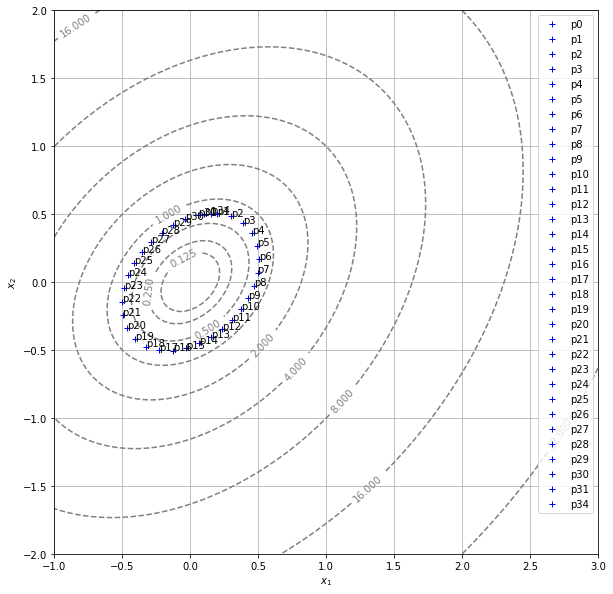

In [74]:
xd,yd=0.1,0.5
(level_curve2(f1, xd, yd, 0.1, 35)) #partir d'un bon point)


0.7650530539583064 0.20908503520427799
True


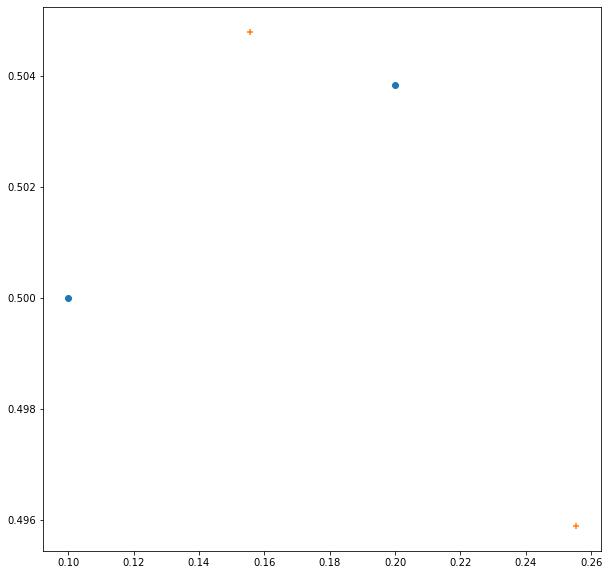

In [75]:
a,b,c,d=(0.1, 0.5),(0.1999264513343047, 0.5038346217196539),(0.15562374240823013, 0.5047971896442963),(0.2552257743563763, 0.49588454515455743)
plt.scatter(*list(zip(*[a,b])))
plt.scatter(*list(zip(*[c,d])), marker='+')
print(intersect_s(a,b,c,d))

#### Tâche 5

Valider graphiquement le résultat au moyen des exemples de référence.

## Post-traitement

Pour améliorer le rendu des courbes de niveau, il est tentant de diminuer la distance $\delta$ entre deux points consécutifs. Malheureusement, dans des cas d'usage réalistes, il est fréquent que la fonction $f$ soit beaucoup plus complexe que les exemples qui nous avons considérés. Le nombre de fois où cette fonction est appelée est alors le principal facteur qui détermine le temps de calcul des lignes de niveau. On cherche donc dans cette section à améliorer la qualité visuelle des résultats sans faire exploser le nombre d'évaluation de la fonction $f$. On va chercher à résoudre ce problème en reliant les points successifs par des chemins plus "flexibles" que des segments de droites, ayant le potentiel de mieux coller aux lignes de niveau.

### Interpolation 

#### Question 8

Soit $P_1$ et $P_2$ deux points du plan et $u_1$ et $u_2$ deux vecteurs du plan non nuls.
On cherche à produire un chemin $\gamma: [0,1] \to \mathbb{R}^2$ continûment différentiable, joignant $P_1$ et $P_2$ ($\gamma(0) = P_1$ et $\gamma(1) = P_2$), tel que $\gamma'(0)$ soit dans la même direction et le même sens que $u_1$ et $\gamma'(1)$ soit dans la même direction et le même sens que $u_2$.

On recherche une telle solution sous la forme
$\gamma(t) = (x(t), y(t))$ où 
$$
x(t) = a + bt + ct^2 \; \mbox{ et } \; y(t) = d + et + ft^2
$$
et les paramètres réels $a, b, c, d, e, f$ sont à déterminer(*).


Déterminer les coefficients $a, b, c, d, e, f$ solutions de ce problème quand ils existent.
Expliciter si nécessaire les conditions que doivent remplir $P_1$, $P_2$, $u_1$ et $u_2$ pour qu'une solution existe.

(*) Cf. ["Mathematical Typography" de Donald E. Knuth](https://projecteuclid.org/euclid.bams/1183544082) pp. 354-359 (Bull. Amer. Math. Soc. (N.S.), Volume 1, Number 2 (1979), 337-372), pour une classe de chemins interpolants similaire mais plus complexe.

#### Tâche 6

Implémenter la solution sous la forme d'une fonction `gamma` dont les arguments sont `t`, `P1`, `P2`, `u1` et `u2` et qui renvoie le ou les points $\gamma(t)$ associés. Lorsqu'il n'existe pas de chemin de la forme souhaitée pour les paramètres `P1`, `P2`, `u1` et `u2`, on utilisera comment remplacement de $\gamma$ un chemin rectiligne interpolant linéairement les points $P_1$ et $P_2$.

Pour des raisons de performance, on vectorisera cette fonction par rapport à `t` : 

  - en acceptant comme argument `t` des tableaux NumPy (monodimensionels) de nombres flottants et en renvoyant alors un tableau de taille `(2, len(t))` flottants décrivant l'abscisse et l'ordonnée des `len(t)` points $\gamma(t)$ correspondant,

  - en appliquant directement opérateurs et fonctions mathématiques aux tableaux NumPy, sans utiliser de boucle `for`,
  
On validera ensuite graphiquement l'implémentation sur un exemple où l'on représentera les point $P_1$ et $P_2$, les tangentes associées et le chemin $\gamma$ correspondant.




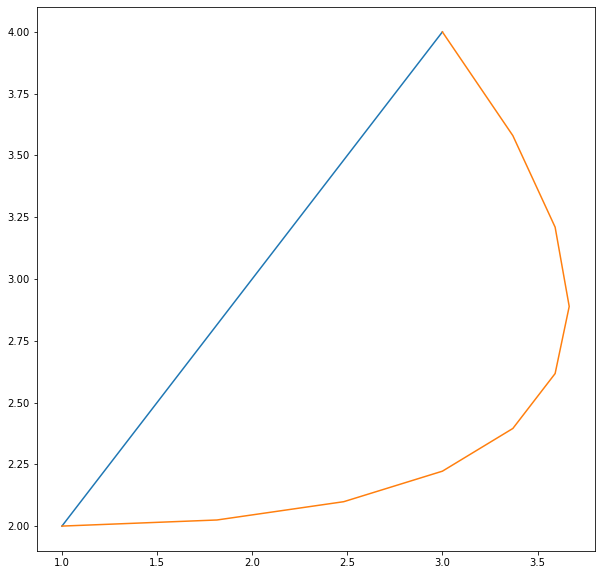

In [21]:
def gamma(t, p1, p2, u1, u2):
    a = np.array([[1,0,0,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,1,0,0,0,0,-u1[0],0],[0,0,0,0,1,0,-u1[1],0],[1,1,1,0,0,0,0,0],[0,0,0,1,1,1,0,0],[0,1,2,0,0,0,0,-u2[0]],[0,0,0,0,1,2,0,-u2[1]]])
    y = np.array([p1[0],p1[1],0,0,p2[0], p2[1],0,0]).reshape((8,1))
    x = None
    if np.linalg.det(a) != 0:
        x = np.dot(np.linalg.inv(a), y)
    if (x.all()!=None) and ((x[6] > 0) and (x[7] > 0)):
        #print("ok")
        #print(x)
        def fx(t0):
            return x[0]+x[1]*t0+x[2]*t0**2
        def fy(t0):
            return x[3]+x[4]*t0+x[5]*t0**2
        return list(zip(fx(t), fy(t)))
    else:
        def fx(t0):
            return p1[0]+(p2[0]-p1[0])*t0
        def fy(t0):
            return p1[1]+(p2[1]-p1[1])*t0
        return list(zip(fx(t), fy(t)))
    #print(y)
    #print(a)

#type de retour??

p1,p2 = [1,2],[3,4]
u1, u2 = [1,0],[-1,1]
#u1, u2 = [5,6],[7,8]
t= np.linspace(0,1,10)
pts = (gamma(t,p1,p2,u1,u2))
plt.plot(*zip(*[p1,p2]))
plt.plot(*zip(*pts))
#https://stackoverflow.com/questions/21519203/plotting-a-list-of-x-y-coordinates-in-python-matplotlib

### Intégration

#### Tâche 7
Intégrer le mécanisme d'interpolation dans (une nouvelle version de) la fonction `level_curve` qui accepte un nouveau paramètre entier `oversampling` (sur-échantillonnage) tel que :

  - si `oversampling == 1`, la fonction `level_curve` fonctionne comme précédemment,

  - si `oversampling > 1`, la fonction `level_curve` introduit dans son résultat `oversampling - 1` points supplémentaires obtenus par interpolations entre chaque couple de points consécutifs obtenus par la méthode de Newton.

In [22]:

def level_curve3(f, x0, y0, delta=0.1, N=1000, eps=eps, oversampling=5):
    #print("g", gx,gy)
    #lagragien, problème de dimension sinon
    c=f(x0,y0)
    def fbis(x,y,xd,yd):
        #d = np.linalg.det(np.array([[x-x0,gx],[y-y0,gy]]))
        #print("d", d, "fin")
        return np.array([f(x,y)-c,(x-xd)**2+(y-yd)**2-delta**2])

        
    plt.close()
    display_contour(
        f, 
        x=np.linspace(-1.0, 3.0, 100), 
        y=np.linspace(-2.0, 2.0, 100), 
        levels=[2**i for i in range(-3, 8)]
    )

    def dir(x,y):        
        gx,gy= grad(f)(x,y)
        return gy,-gx
    #print("fb", fbis(x0,y0))
    t = [(x0, y0)]
    bi = N-1
    for i in range(N-1):
        plt.plot([t[-1][0]], [t[-1][1]],'+',color='b', label=f"p{i}")
        plt.annotate(f"p{i}", (t[-1][0], t[-1][1]))
        ux,uy=dir(t[-1][0], t[-1][1])
        nu = np.linalg.norm(np.array([ux,uy]),2)
        ux,uy=ux/nu*delta,uy/nu*delta
        t.append(Newton(lambda x,y: fbis(x,y, t[-1][0], t[-1][1]), t[-1][0]+ux, t[-1][1]+uy))        
        if oversampling > 1:
            t0 = np.linspace(0,1,oversampling-1)
            #print("t", t0)
            ux2,uy2=dir(t[-1][0], t[-1][1]) #calcul redondant
            plt.plot(*zip(*gamma(t0,t[-2],t[-1],[ux,uy],[ux2,uy2])), marker='x')
        if (len(t)>=4) and intersect(t[0], t[1],t[-2], t[-1]):#évaluation paresseuse
            print("recoupe", i)
            bi = i+1
            break
            
    
    plt.plot([t[-1][0]], [t[-1][1]],'+',color='b', label=f"p{bi}") #fonciotn qui trace 
    plt.annotate(f"p{bi}", (t[-1][0], t[-1][1]))
    plt.legend()
    return np.array(t).reshape(2,len(t)) # pas N si array avant

recoupe 10


array([[ 0.1       ,  0.5       ,  0.39192345,  0.43085738,  0.50471201,
         0.15286685,  0.41475751, -0.13332922,  0.21618115, -0.35820125,
        -0.05278483, -0.49108202],
       [-0.35108883, -0.45922726, -0.50375636, -0.2009781 , -0.43764045,
         0.09164569, -0.25276135,  0.32790767,  0.00680718,  0.47832103,
         0.30679984,  0.48041868]])

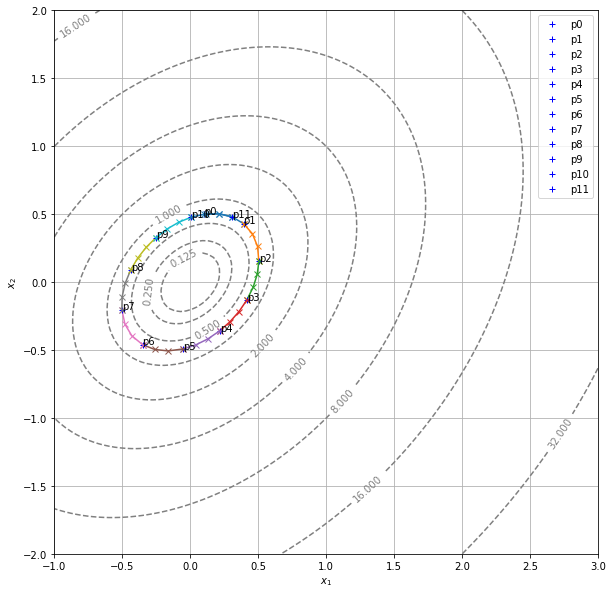

In [23]:
xd,yd=0.1,0.5
(level_curve3(f1, xd, yd, 0.3, 15)) 
#arrêt ligne de niveau après recoupe !

recoupe 29


array([[ 0.8       ,  0.8       ,  0.86421029,  0.72333816,  0.91431887,
         0.63679839,  0.94983151,  0.54331657,  0.971229  ,  0.44563265,
         0.97957856,  0.34598184,  0.97617428,  0.2460398 ,  0.96230579,
         0.14700614,  0.9391451 ,  0.0497252 ,  0.90770841, -0.04520496,
         0.86885615, -0.13734888,  0.82330901, -0.22637392,  0.7716687 ,
        -0.31200848,  0.71443836, -0.39401268,  0.65204082, -0.47215708,
         0.58483457, -0.54620652],
       [ 0.51312757, -0.61590663,  0.43718984, -0.68097169,  0.35726548,
        -0.74107241,  0.27358526, -0.79582294,  0.1863811 , -0.84476612,
         0.09590425, -0.88735649,  0.00244974, -0.92294096, -0.09360925,
        -0.9507379 , -0.19177221, -0.96981757, -0.29134126, -0.97909147,
        -0.39132567, -0.97732597, -0.49032424, -0.96320923, -0.58641237,
        -0.93551315, -0.67710593, -0.89338624, -0.75952014, -0.83674793,
        -0.83080582, -0.76661697]])

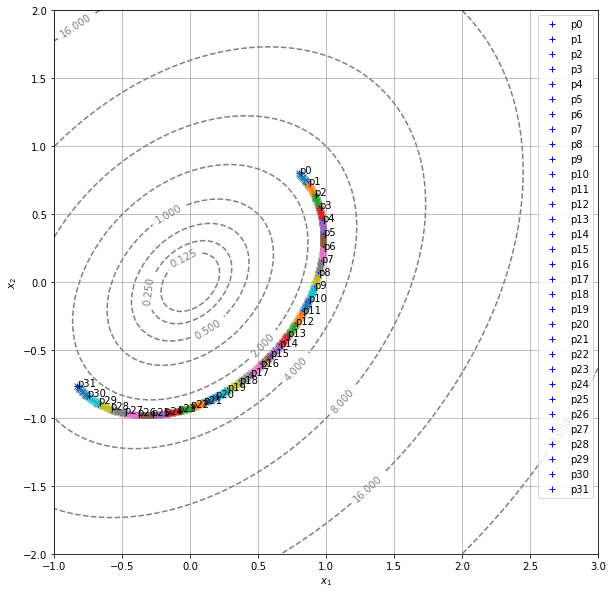

In [26]:
xd,yd=0.1,0.5
(level_curve3(f2, xd, yd, 0.3, 32, eps, 15)) 
(level_curve3(f1, 0.8, 0.8, 0.1, 32, eps, 15)) 

#### Tâche 8

Valider graphiquement le résultat au moyen des exemples de référence.

In [25]:
#changer le graphe de points des lignes de niveau pour vérifier